# Group Formation Notebook (vectorized)

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
final_fig_path = "../Figures/"
from time import time
import sys
sys.path.insert(1, 'Functions')
from fitness_funs import *
from fun_response_funs import *
from group_formation_funs import *
from group_formation_measures import *

In [2]:

def run_simulations_vary_param(p, M1, M2, param_vec, param_key, params, pop_process = False, 
                               t_f = 10, delta_t = 0.01,
                               initialstate = np.nan):
    '''
    runs the ode system for dfdt over a list of param values for one of the params (e.g. s_2, s_1, etc...)
    @inputs
    p, M1, M2 - pop sizes of pred, big prey, small prey, respec
    param_vec = list of param values to run simulation for, corresponding to param_key
    param_key = name of parameter varied in param_vec
    params = dic of param values
    pop_process = True or False, whether or not to include death rate and birth rate
    t_f = final time for simulation (note that t_f = 10 is still many steps of group simulation
    delta_t = time step
    initialstate - optional input, list of length x_max of num grps of size 1, 2, 3, ..., x_max

    
    @returns: 
    final_f_of_x - array of f(x) vectors (for x = 1, 2, ..., x_max) 
                    for each parameter value (one row per param value)
    at_equilibrium - whether each f(x) vector is at the stationary distribution, 
        1 for at equilibrium, 0 for no
    
    '''
    x_max = params["x_max"]
    if not isinstance(initialstate,np.ndarray): # otherwise it's an array, and intiial state is given
        if np.isnan(initialstate):
            initialstate = np.array([p, *np.zeros(x_max - 1)])

    final_f_of_x = np.zeros((len(param_vec), x_max))
    at_equilibrium = np.zeros(len(param_vec))
    dfdt_final = np.zeros((len(param_vec), x_max))
    
    # run model for each parameter value
    for i, param in enumerate(param_vec):
        # put new parameter values into params dictionary
        if isinstance(param_key, list): # in case want to set multiple params to same value
            for pkey in param_key:
                params[pkey] = param
        else:
            params[param_key] = param

        # run the model using LSODA, like in odeint?
        tsteps = 100
        #t_eval =  np.arange(0.0, t_f, delta_t)
        #out = solve_ivp(group_formation_model_separate, [0, t_f], initialstate, method="RK45",
        #        args=(p, M1, M2, pop_process, params))
        out = solve_ivp(group_formation_model_separate, [0, t_f], initialstate, method="LSODA",
                args=(p, M1, M2, params))
        final_distribution = np.transpose(out.y)[-1]
        
        # check at equilibrium
        dfdt_final[i,:], at_equilibrium[i] = check_at_equilibrium(final_distribution, p, M1, M2,pop_process,**params)
        
        
        final_f_of_x[i,:] = final_distribution
        

    return final_f_of_x, at_equilibrium, dfdt_final



def run_simulations_vary_param2(p, M1, M2, param_vec1, param_vec2,
                                param_key1, param_key2, params, pop_process = False,
                                t_f = 1e5,
                               initialstate = np.nan):
    '''
    run_simulations_vary_param, but with 2 parameters you're varying!
    @inputs
    p, M1, M2 - pop sizes
    param_vec1 - list of values for first param to vary by
    param_vec2 - list of values for 2nd param 
    param_key1, param_key2 - names of 1st and 2nd params being varied, respec
    params - dic of other params in the model
    @returns: 
    list_of_f_of_x - list of f(x) arrays. The rows of the arrays corresponds to param1, the arrays themselves 
        correspond to param2
    list_at_equilibrium - says whether each f(x) vector is at the stationary distribution, 1 for at equilibrium, 
            0 for no
    list_of_df_dt - df_dt at final step of simulation
'''

    list_of_f_of_x = [] # should be a list of lists of lists
    list_at_equilibrium = []
    list_of_df_dt = []
    for i, param2 in enumerate(param_vec2):
        params[param_key2] = param2
        out = run_simulations_vary_param(p, M1, M2, param_vec1, 
                                         param_key1, params, pop_process = pop_process,  
                                         t_f = t_f, initialstate = initialstate)
        final_f_of_x, at_equilibrium, dfdt_final = out
        list_of_f_of_x.append(final_f_of_x) # note that final_f_of_x includes f(1)
        list_at_equilibrium.append(at_equilibrium)
        list_of_df_dt.append(dfdt_final)
    return list_of_f_of_x, list_at_equilibrium, list_of_df_dt
    
        
'''
    try:
        if x == 2:
            join_smaller_grp = f(1)*f(x-1)*ψ(x-1)
            #join_smaller_grp = (1/2)*f(1)*(f(1)-1)*ψ(1)
        else:
            join_smaller_grp = f(1)*f(x-1)*ψ(x-1)
    except ValueError:
        join_smaller_grp = np.zeros(np.shape(x))
        join_smaller_grp = f(1)* f(x-1) * ψ(x-1)
        #join_smaller_grp[x==2] = (1/2)*f(1) *(f(1)-1)*ψ(1)
        #join_smaller_grp[x>2] = f(1)*f(x[x>2] - 1) * ψ(x[x>2] - 1)
'''

'\n    try:\n        if x == 2:\n            join_smaller_grp = f(1)*f(x-1)*ψ(x-1)\n            #join_smaller_grp = (1/2)*f(1)*(f(1)-1)*ψ(1)\n        else:\n            join_smaller_grp = f(1)*f(x-1)*ψ(x-1)\n    except ValueError:\n        join_smaller_grp = np.zeros(np.shape(x))\n        join_smaller_grp = f(1)* f(x-1) * ψ(x-1)\n        #join_smaller_grp[x==2] = (1/2)*f(1) *(f(1)-1)*ψ(1)\n        #join_smaller_grp[x>2] = f(1)*f(x[x>2] - 1) * ψ(x[x>2] - 1)\n'

# Plot Functions

In [61]:
colors = ['k','r','b','cyan']
markers = ["o","","v", ""]

def format_ax(ax,xlab,ylab, xlim = None, ylim=None,
              fs_labs = 20, fs_legend = 20, if_legend = False):
    ax.set_xlabel(xlab, fontsize = fs_labs)
    ax.set_ylabel(ylab, fontsize = fs_labs)
    if xlim != None:
        ax.set_xlim(xlim)
    if ylim != None:
        ax.set_ylim(ylim)
    for s in ['top', 'right']:
        ax.spines[s].set_visible(False)
    if if_legend:
        ax.legend(fontsize = fs_legend)
''' 
changing a parameter value, but not x_max!!
len(param_vec) must be 3
example of linelabel: r'$\theta_2=$'+'%d'
param_key may be multiple keys, (the parameter version for big prey and small prey) 
    if they are being set to the same param value
initialstate (optional) is a vector of the number of groups of size 2, 3, ... , x_max
'''
def plot_f_of_x(p, M1, M2,param_vec, param_key, linelabel, params, pop_process = False, 
                delta_t = 0.01, t_f = 10, initialstate = np.nan):
    
    # set up figure
    
    fig,ax = plt.subplots(1,1,figsize = (6,5))

    # run simulation for each parameter
    out = run_simulations_vary_param(p, M1, M2, param_vec, param_key, params, delta_t = delta_t, t_f = t_f,
                               initialstate = np.nan)
    
    final_f_of_x, at_equilibrium, dfdt_final = out

    # plot the distribution f(x)
    x_max = params["x_max"]
    for i, param in enumerate(param_vec):
        full_f_vec = final_f_of_x[i]
        ax.plot(np.arange(1,x_max+1,1),full_f_vec,color = colors[i], marker = markers[i],label = linelabel %param)

    # format the figure
    format_ax(ax,xlab = r'Group Size $x$', ylab = r'Num. groups of size $x$, $f(x)$', 
              xlim=[0,x_max], if_legend = True)

    
    return fig, ax, final_f_of_x, at_equilibrium, dfdt_final


    
def plot_mean_grp_membership(param_vec, list_f_of_x, x_max, xlab, type = 'bar'):
    
    mean_group_size_membership_vec = [mean_group_size_membership(f_vec,p,x_max)\
                                      for f_vec in list_f_of_x]
    fig,ax = plt.subplots(1,1,figsize=(6,5))
    if type == 'bar':
        param_vec_str = [str(param) for param in param_vec]
        plt.bar(param_vec_str,mean_group_size_membership_vec, width = 0.3)
        for i,bar in enumerate(ax.patches):
            ax.text(bar.get_x()+0.05,bar.get_height()+0.2, 
                 str(round(mean_group_size_membership_vec[i],2)),
                fontsize = 10, fontweight = 'bold')
    elif type == 'line':
        plt.plot(param_vec, mean_group_size_membership_vec)
    ymax = np.max(mean_group_size_membership_vec)+0.5
    format_ax(ax,xlab=xlab,ylab='Mean Group Membership',ylim=[0,ymax])

    return fig, ax, mean_group_size_membership_vec
    
    
    

'''
plots the number of individuals in groups of size x (the x-axis is, y-axis is number of individuals)

'''
def plot_group_membership_hist(param_vec, f_vec_list, x_max, linelabel):
    
    fig,ax = plt.subplots(1,1,figsize = (6,5))
    for i,f_vec in enumerate(f_vec_list):
        xvec = list(range(1,x_max+1))
        membership_vec = [x*f_vec[x-1] for x in xvec]
        ax.plot(xvec, membership_vec, label = linelabel %param_vec[i], c = colors[i])
    format_ax(ax, xlab='Group Size', ylab = 'Number of Individuals', if_legend=True)

    return fig, ax



def plot_mean_grp_membership_2params(p, M1, M2, param_key1, param_vec1,
                                     param_key2, param_vec2, params, linelabel, xlabel,
                                     t_f = 1, f_of_x_vec = np.nan, ylim = None):
    '''
    Plot mean group size an individual is part of versus 2 paramers
    param1 is on the x-axis, param2 is the color of the lines
    can only have 3 values for param2
    @returns: fig, ax, list_at_equilibrium, list_of_meanx
    '''
    
    fig, ax = plt.subplots(1,1,figsize = (5,6))
    x_max = params['x_max']

    # simulate
    out = run_simulations_vary_param2(p, M1, M2, param_vec1, param_vec2,
                                param_key1, param_key2, params, 
                                      t_f = t_f, initialstate = f_of_x_vec)
    list_of_f_of_x, list_at_equilibrium, _ = out
    list_of_meanx = [[mean_group_size_membership(f_vec,p,x_max)\
                                      for f_vec in list_f] \
                 for list_f in list_of_f_of_x]
    # plot the simulation
    colors = ['k','r','b','cyan']
    for i, param2 in enumerate(param_vec2):
        plt.plot(param_vec1, list_of_meanx[i], c = colors[i], label = linelabel%param2)

    # format the plot
    format_ax(plt.gca(),xlab = xlabel,
          ylab = 'Expected Group Size\nof Individual', 
          xlim = None, ylim=ylim, fs_labs = 20, fs_legend = 16, if_legend = True)
    return fig, ax, list_at_equilibrium, list_of_meanx, list_of_f_of_x
    
'''
This plots different aspects of the model(specified by funhandle) that change with group size
'''
def plot_measure_vs_grp_size(paramkey, param_vals, linelabel, 
                             ylabel, funhandle, args, params):
    #colors = ['k', 'r', 'b']
    fig, ax = plt.subplots(1,1,figsize = (5,6))
    
    x_max = params["x_max"]
    x_inputs = np.arange(1,x_max+1,1)
    for i,param in enumerate(param_vals):
        params[paramkey] = param
        out_vec = funhandle(x_inputs, *args, **params)
        ax.plot(x_inputs, out_vec, c=colors[i], label = linelabel %param)
    format_ax(ax, xlab = r'Group Size $x$', ylab = ylabel, if_legend=True)
    return fig, ax

# Base parameters

In [68]:
# base parameter and population size names
p_reg = 100
M1_reg = 100; M2_reg = 100
h_reg = 0.2
params_reg = dict(b1=1,b2=0.1,a1 = 1, a2 = 1, h1 = h_reg,h2 = h_reg, 
                  α1_of_1 = 0.02, α2_of_1 = 0.98, 
                  s1 = 2, s2 = 2, δ=0, τx=0.01, r=0,γ=0, x_max=10, 
                  d = 100, limited_portions = False)


In [8]:
(p, M1, M2, param_vec1, param_vec2,
                                param_key1, param_key2, params, pop_process = False,
                                t_f = 1e5,
                               initialstate = np.nan)

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (1219753458.py, line 2)

/Users/taliaborofsky/Documents/Postdoc/ReproductiveExchange/Code/Functions/group_formation_funs.py:162: RuntimeWarning: overflow encountered in scalar power
  return W_of_x**d/(W_of_x**d + W_of_y**d)
/Users/taliaborofsky/Documents/Postdoc/ReproductiveExchange/Code/Functions/group_formation_funs.py:162: RuntimeWarning: invalid value encountered in scalar divide
  return W_of_x**d/(W_of_x**d + W_of_y**d)


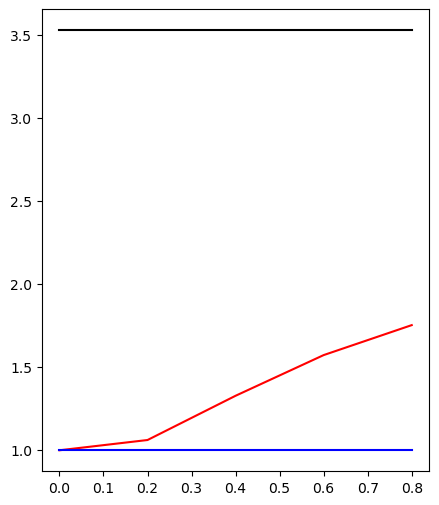

In [66]:
fig, ax = plt.subplots(1,1,figsize = (5,6))
params = params_reg.copy()
x_max = params['x_max']
p=p_reg; M1=M1_reg; M2 = M2_reg
param_vec1 = np.arange(0,0.9,0.2)
param_key1=['h1','h2']
param_key2 = 's1'; param_vec2 = [2,4,6]
t_f = 1
f_of_x_vec = np.nan
out = run_simulations_vary_param2(p, M1, M2, param_vec1, param_vec2,
                                param_key1, param_key2, params, 
                                      t_f = t_f, initialstate = f_of_x_vec)
list_of_meanx = [[mean_group_size_membership(f_vec,p,x_max)\
                                      for f_vec in list_f] \
                 for list_f in list_of_f_of_x]
colors = ['k','r','b','cyan']
linelabel = r'$s_1=$'+'%d'
for i, param2 in enumerate(param_vec2):
    plt.plot(param_vec1, list_of_meanx[i], c = colors[i], label = linelabel%param2)

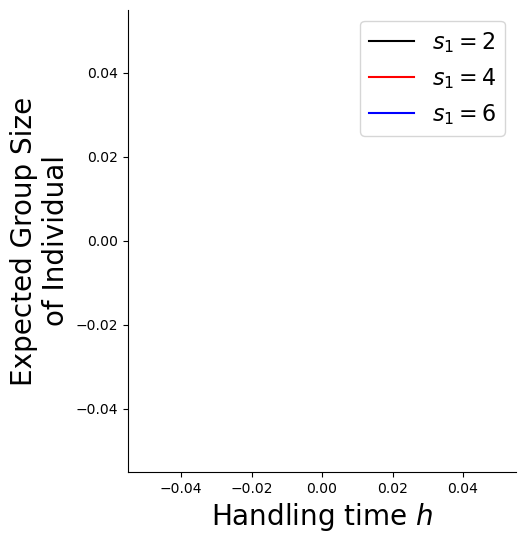

In [67]:
out = plot_mean_grp_membership_2params(p=p_reg, M1=M1_reg, M2 = M2_reg, 
                                 param_key1=['h1','h2'], 
                                 param_vec1 = np.arange(0,0.9,0.2), 
                                 param_key2 = 's1', param_vec2 = [2,4,6], 
                                 params = params_reg.copy(), 
                                 linelabel = r'$s_1=$'+'%d', 
                                 xlabel = r'Handling time $h$',
                                     t_f = 600, 
                                 f_of_x_vec = np.nan, ylim = None)

# Plots

In [6]:
p = p_reg
M1 = M1_reg; M2 = M2_reg

params = params_reg.copy()


param_vec = [2,4,6,8]
param_key = "s2"
final_f_of_x2, at_equilibrium, dfdt_final = run_simulations_vary_param(p, M1, M2, param_vec, 
                                                          param_key, params, pop_process = False,
                                                          t_f = 50, delta_t = 0.01, initialstate = np.nan)

(<Figure size 500x600 with 1 Axes>,
 <Axes: xlabel='Group Size $x$', ylabel='fitness'>)

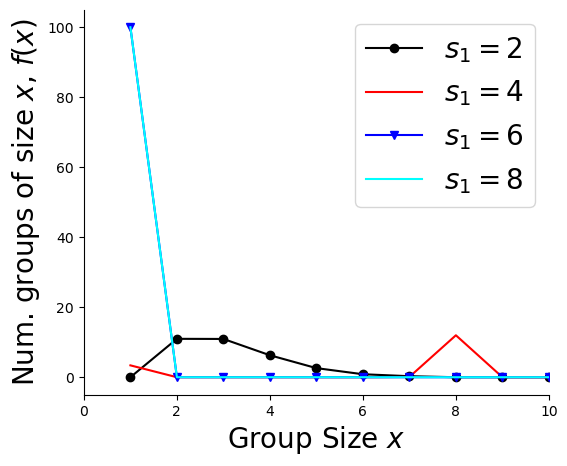

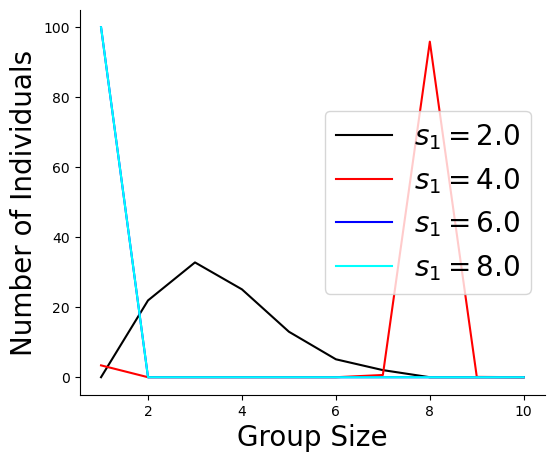

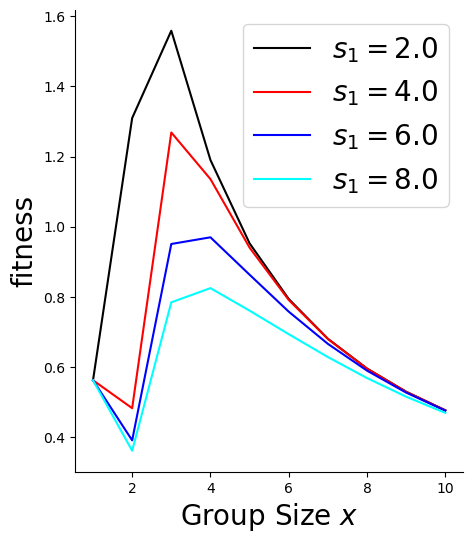

In [64]:
out = plot_f_of_x(p=p_reg, M1=M1_reg, M2=M2_reg,
                  param_vec = [2,4,6,8], param_key="s1", 
            linelabel = r'$s_1=$'+'%d', params = params_reg.copy(), pop_process = False, 
                delta_t = 0.01, t_f = 5000, initialstate = np.nan)
fig, ax, final_f_of_x, at_equilibrium, dfdt_final = out
plot_group_membership_hist(param_vec=param_vec, f_vec_list=final_f_of_x, 
                           x_max=params['x_max'], 
                           linelabel=r'$s_1=$'+'%.1f')

plot_measure_vs_grp_size(paramkey='s1', param_vals=[2,4,6,8], 
                         linelabel=r'$s_1=$'+'%.1f', 
                             ylabel = 'fitness', funhandle=fun_fitness, 
                         args=[M1_reg, M2_reg], params = params_reg.copy())

[0.561904761904762,
 1.3095238095238095,
 1.5587301587301585,
 1.1900301336188095,
 0.952373666848805,
 0.7936506697461538,
 0.6802721066761088,
 0.5952380951993911,
 0.529100529099827,
 0.47619047619046334]

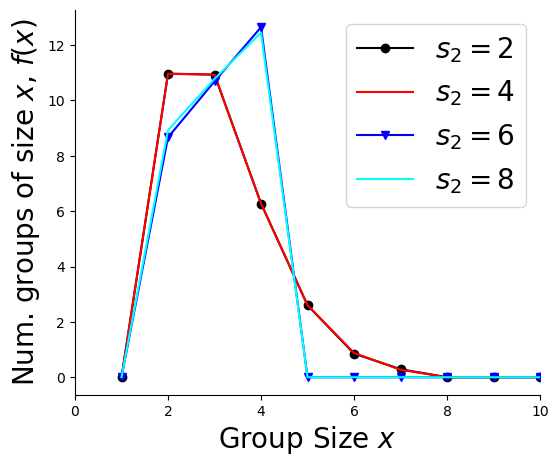

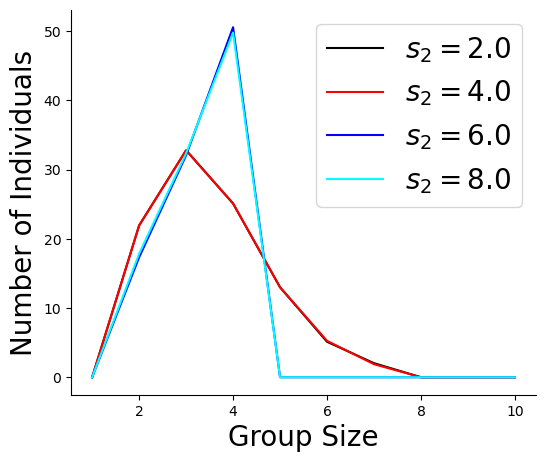

In [54]:
out = plot_f_of_x(p=p_reg, M1=M1_reg, M2=M2_reg,
                  param_vec = [2,4,6,8], param_key="s2", 
            linelabel = r'$s_2=$'+'%d', params = params_reg.copy(), 
                  pop_process = False, 
                delta_t = 0.01, t_f = 5000, initialstate = np.nan)
fig, ax, final_f_of_x, at_equilibrium, dfdt_final = out
plot_group_membership_hist(param_vec=param_vec, f_vec_list=final_f_of_x, 
                           x_max=params['x_max'], 
                           linelabel=r'$s_2=$'+'%.1f')
x_max = params_reg['x_max']



(<Figure size 600x500 with 1 Axes>,
 <Axes: xlabel='Group Size', ylabel='Number of Individuals'>)

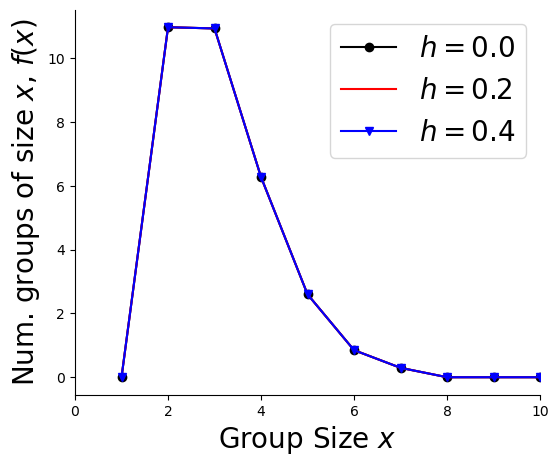

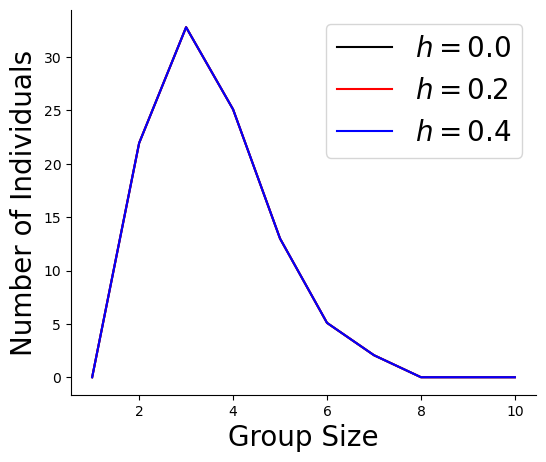

In [201]:
p = p_reg
M1 = M1_reg; M2 = M2_reg

params = params_reg.copy()


param_vec = [0, 0.2, 0.4]
param_key = ['h1','h2']
fig, ax, final_f_of_x, at_equilibrium, dfdt_final = plot_f_of_x(p=p_reg, M1=M1_reg, M2=M2_reg,
                                                                param_vec = param_vec, param_key=param_key, 
            linelabel = r'$h=$'+'%.1f', params = params, pop_process = False, 
                delta_t = 0.01, t_f = 500, initialstate = np.nan)
plot_group_membership_hist(param_vec=param_vec, f_vec_list=final_f_of_x, x_max=params['x_max'], 
                           linelabel=r'$h=$'+'%.1f')

In [95]:
M1

100

(<Figure size 600x500 with 1 Axes>,
 <Axes: xlabel='Group Size', ylabel='Number of Individuals'>)

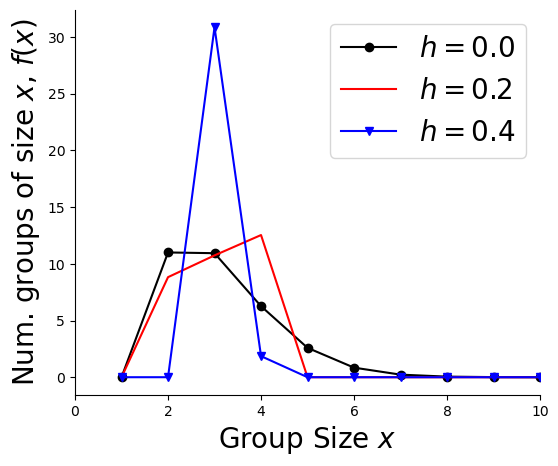

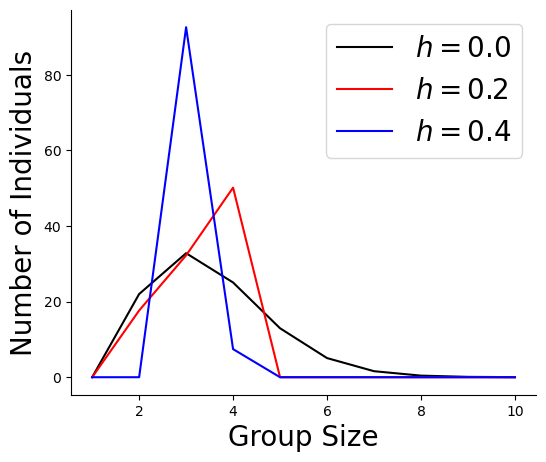

In [174]:
p = p_reg
M1 = M1_reg; M2 = M2_reg/10

params = params_reg.copy()
params['s2'] = 2
params['x_max'] = 10
param_vec = [0, 0.2, 0.4]
param_key = ['h1','h2']
fig, ax, final_f_of_x, at_equilibrium, dfdt_final = plot_f_of_x(p=p, M1=M1, M2=M2,
                                                                param_vec = param_vec, param_key=param_key, 
            linelabel = r'$h=$'+'%.1f', params = params, pop_process = False, 
                delta_t = 0.01, t_f = 2e6, initialstate = np.nan)
plot_group_membership_hist(param_vec=param_vec, f_vec_list=final_f_of_x, x_max=10, 
                           linelabel=r'$h=$'+'%.1f')

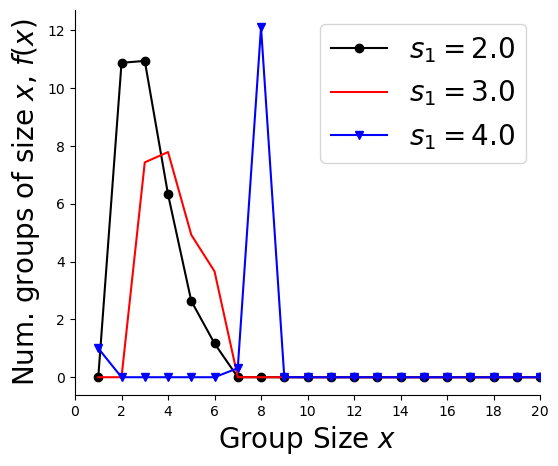

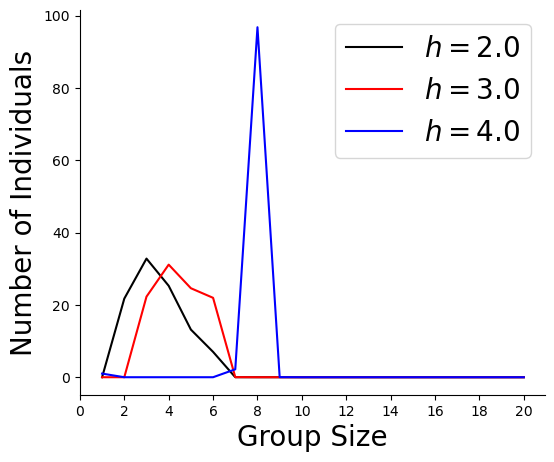

In [184]:
p = p_reg
M1 = M1_reg; M2 = M2_reg

params = params_reg.copy()
params['s2'] = 2
params['x_max'] = 20
param_vec = [2,3,4]
param_key = ['s1']
fig, ax, final_f_of_x, at_equilibrium, dfdt_final = plot_f_of_x(p=p, M1=M1, M2=M2,
                                                                param_vec = param_vec, param_key=param_key, 
            linelabel = r'$s_1=$'+'%.1f', params = params, pop_process = False, 
               t_f = 2e6, initialstate = np.nan)
plt.xticks(np.arange(0, params['x_max']+2, step=2));
plot_group_membership_hist(param_vec=param_vec, f_vec_list=final_f_of_x, x_max=params['x_max'], 
                           linelabel=r'$h=$'+'%.1f')
plt.xticks(np.arange(0, params['x_max']+2, step=2));

In [164]:
np.sum(dfdt_final>1e-7,1)

array([0, 0, 1])

In [128]:
dfdt_final

array([[ 6.13137510e-87, -1.57948166e-80, -3.83222037e-82,
         4.81508998e-80, -3.19728613e-80],
       [-2.06795153e-23, -3.73518004e-10,  7.47036008e-10,
        -3.73518004e-10, -1.03559701e-19],
       [-8.39409651e-17, -4.14337175e-09,  8.28699545e-09,
        -4.14356069e-09, -8.43116764e-20]])

In [48]:
dfdt_final

array([[ 7.03398704e-29, -9.22689862e-21, -2.23867803e-22,
         2.81284315e-20, -1.86776651e-20],
       [-1.34021638e-06, -3.15922049e-02, -3.93871189e-03,
         1.02652965e-01, -6.71219947e-02],
       [-1.12634868e-16, -8.72202160e-07,  1.74440432e-06,
        -8.72202153e-07, -3.34964241e-15]])

In [47]:
sum(dfdt_final>1e-4)

array([0, 0, 0, 1, 0])

In [10]:
at_equilibrium

array([1., 0., 0.])

In [16]:
dfdt_final<1e-4

array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True]])

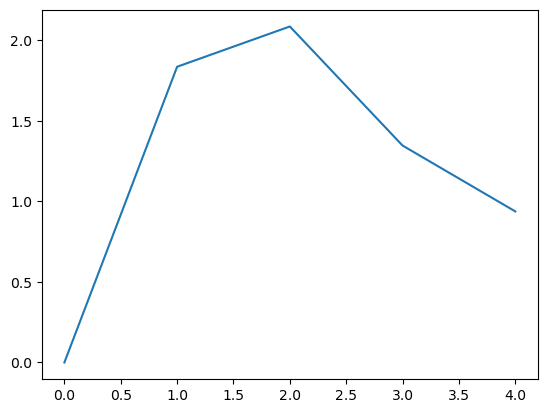

In [9]:
plt.plot(final_f_of_x2[0])

In [47]:
final_f_of_x2 - final_f_of_x1

array([[ 3.99613380e-07,  1.28867747e-07,  1.59301443e-08,
        -5.58513717e-08, -9.63467653e-08],
       [ 4.02578614e-07, -4.48717812e-07, -7.31897210e-08,
         1.85811021e-06, -1.34360294e-06],
       [ 1.48870001e-06, -1.33399680e-04, -2.06019715e-05,
         4.42854690e-04, -2.88860437e-04]])

In [40]:
at_equilibrium

array([0., 0., 0.])

In [33]:
group_formation_model_separate(t=3, f_of_x_vec = np.array(final_, p=p_reg, M1=M1_reg, M2=M2_reg, params = params_reg.copy())

array([-0.00359139, -0.00137048, -0.00021146,  0.00094298,  0.00063896])

In [25]:
xvec = np.arange(1,6,1)

In [28]:
sum(np.array([2.75936321e-07, 1.80227458e+00, 2.08036018e+00, 1.35207083e+00,
         9.49217346e-01]) * xvec)

20.000000025936323

TypeError: per_capita_fitness_from_prey() missing 1 required positional argument: 'limited_portions'

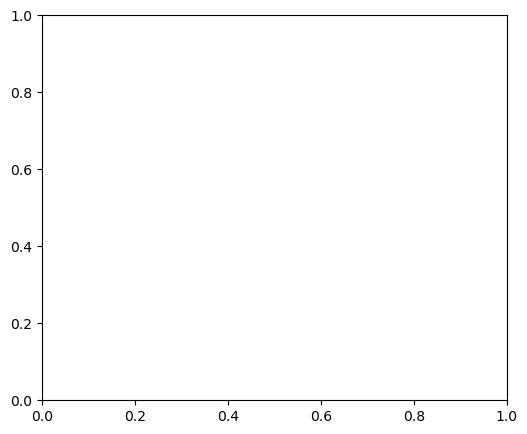

In [20]:
p = p_reg
M1 = M1_reg; M2 = M2_reg

params = params_reg.copy()


param_vec = [2,6,8]
param_key = "s2"
linelabel = r'$s_2=$'+'%d'

fig, ax, full_f_vecs, at_equilibrium = plot_f_of_x(p, M1, M2,param_vec, param_key, 
                                                                  linelabel, params, 
                                                                  delta_t = 0.1, t_f = 50000)

In [13]:
params = dict(b1 = 1, b2 = 0.1, α1_of_1 = 0.05, α2_of_1 = 0.95, s1 = 2, s2 = 8, 
              a1=1,a2=1, h1=0, h2=0, r = 0, γ = 0,
             limited_portions=False, x_max = 3, δ = 0, τx = .01, d = 100)
p_reg = 50; M1_reg = 100; M2_reg = 100; x_max = params['x_max']
initialstate = np.array([p_reg, *np.zeros(x_max - 1)]);
t_f = 2
out = solve_ivp(group_formation_model_separate, [0, t_f], initialstate, method="LSODA",
                args=(p_reg, M1_reg, M2_reg, params))

In [14]:
group_formation_model_separate(t=t_f, f_of_x_vec = out.y[:,-1],p = p_reg,M1 = M1_reg,M2 =M2_reg, params=params)

array([ 1.99167106e-14,  1.99167106e-14, -1.99167106e-14])

In [16]:
check_at_equilibrium(out.y[:,-1], p_reg, M1_reg, M2_reg,pop_process =False,**params)

1

In [4]:
sum(np.arange(1,4,1)*out.y[:,-1])

50.00000000000003

In [7]:
np.sum(np.arange(1,4,1)*np.transpose(out.y)[-1,:])

68.11196484054952

In [17]:
final_f_of_x, at_eq = run_simulations_vary_param(p_reg, M1_reg, M2_reg, 
                                                 param_vec, param_key, params_reg, 
                                                 pop_process = False, t_f = 1, 
                                                 delta_t = 0.01, initialstate = np.nan)

NameError: name 'param_vec' is not defined

In [6]:
final_f_of_x

array([[ 4.68414371,  1.84015301,  0.39276868,  0.08388334, 10.98855289],
       [ 4.68414371,  1.84015301,  0.39276868,  0.08388334, 10.98855289],
       [ 0.49007555,  0.42168483,  0.58668409,  0.6548075 ,  0.59842897]])

In [7]:
sum(np.arange(1,6,1)*final_f_of_x[0],1)

65.8210535257581

In [27]:
sum(np.arange(1,5+1,1)*final_f_of_x[2])

3.373633227150465

In [19]:
f_of_x_vec = final_f_of_x[2,:]
M1 = M1_reg; M2 = M2_reg
params = params_reg.copy()
x_max = params['x_max']; τx = params['τx']; δ = params['δ']; d = params['d']
xvec = np.arange(1,x_max+1,1)
fitnessvec = fun_fitness(xvec, M1, M2, **params)
Ψ = make_group_form_mat(xvec, f_of_x_vec, fitnessvec, x_max,d)
Φ = make_group_leave_mat(xvec, fitnessvec, x_max, d)

In [24]:
np.round(f_of_x_vec,3)

array([ 18.23 ,   8.56 ,   8.519, 826.152, 323.751,   0.   ,   0.   ,
         0.   ,   0.   ,   0.   ])